In [1]:
import os
import sys
import scipy.io as sio
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

from sklearn import linear_model, preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Palatino Linotype']
rcParams['font.size'] = 18
rcParams['figure.autolayout'] = True

In [2]:
def load_all_files(filedirectory, numfiles):
# Get data from .mat files
# Assumes input data are in the format of time (rows) x channels (columns)
    if len(numfiles) == 0: # numfiles = []
        numfiles_start = 0
        numfiles_end = len(os.listdir(filedirectory + '\\IMU Segmented')) # Use all files in directory
        print('Loading {} processed data file(s) ...'.format(numfiles_end - numfiles_start))     
    else:
        numfiles_start = numfiles[0]
        numfiles_end = numfiles[1]
        print('Loading {} processed data file(s) ...'.format(numfiles_end - numfiles_start))      

    filedict = {}
    allindtrigsdict = {}
    for fileindex, filename in enumerate(sorted(os.listdir(filedirectory + '\\IMU Segmented'))):
        if numfiles_start <= fileindex < numfiles_end:
            print('=== {} ==='.format(filename))

            imu_mat_contents = sio.loadmat(filedirectory + '\\IMU Segmented\\' + filename)
            daqdata = imu_mat_contents['IMU_data_mat']
            # Remove channels associated with shank/thigh orientation estimates using acc/gyro only
            chans = daqdata[:,np.setdiff1d(np.arange(36),np.array([6,7,15,16,24,25,33,34]))]
            
            cam_mat_contents = sio.loadmat(filedirectory + '\\Camera Features\\' + filename[:-13] + 'Combined')                
            Lcam = cam_mat_contents['CFEAT_all'][:,9] # Only use shank angle          
            Rcam = cam_mat_contents['IFEAT_all'][:,0] # Only use ground angle      

            L_trig, R_trig, L_stance, R_stance = daqdata[:,36], daqdata[:,37], daqdata[:,38], daqdata[:,39]

            # Define valid triggers (4-digit)
            hc_sm_trigs = [1311,1321,1331,1341,1351,2311,2321,3311,3331,4311,4341,5311,5351]
            to_sm_trigs = [1112,1122,1132,1142,1152,2112,2122,3112,3132,4112,4142,5112,5152]

            L_trig_diff = np.diff(L_trig)
            L_trig_ind = np.where(L_trig_diff > 0)[0] + 1
            R_trig_diff = np.diff(R_trig)
            R_trig_ind = np.where(R_trig_diff > 0)[0] + 1

            lhc_ind, lto_ind, rhc_ind, rto_ind = [], [], [], []
            lhc_trig, lto_trig, rhc_trig, rto_trig = [], [], [], []

            for i in np.arange(len(L_trig_ind)):
                if L_trig[L_trig_ind[i]] in hc_sm_trigs:
                    lhc_ind.append(int(L_trig_ind[i]))
                    lhc_trig.append(int(L_trig[L_trig_ind[i]]))
                elif L_trig[L_trig_ind[i]] in to_sm_trigs:
                    lto_ind.append(int(L_trig_ind[i]))
                    lto_trig.append(int(L_trig[L_trig_ind[i]]))

            for i in np.arange(len(R_trig_ind)):
                if R_trig[R_trig_ind[i]] in hc_sm_trigs:
                    rhc_ind.append(int(R_trig_ind[i]))
                    rhc_trig.append(int(R_trig[R_trig_ind[i]]))
                elif R_trig[R_trig_ind[i]] in to_sm_trigs:
                    rto_ind.append(int(R_trig_ind[i]))
                    rto_trig.append(int(R_trig[R_trig_ind[i]]))

            lhc_ind, lhc_trig = np.array(lhc_ind), np.array(lhc_trig)
            lto_ind, lto_trig = np.array(lto_ind), np.array(lto_trig)
            rhc_ind, rhc_trig = np.array(rhc_ind), np.array(rhc_trig)
            rto_ind, rto_trig = np.array(rto_ind), np.array(rto_trig)            

            # Save the post-processed data and indices/triggers into dictionaries
            filedict[filename[:-14]] = [chans,Lcam,Rcam,L_trig,R_trig,L_stance,R_stance]
            allindtrigsdict[filename[:-14]] = {'LHC': np.vstack((lhc_ind,lhc_trig)).T, 
                                         'LTO': np.vstack((lto_ind,lto_trig)).T,
                                         'RHC': np.vstack((rhc_ind,rhc_trig)).T, 
                                         'RTO': np.vstack((rto_ind,rto_trig)).T}
    
    print('Finished!')
    return filedict, allindtrigsdict


def unpack_files(filedict, allindtrigsdict, filekeys, arginput):    
    # Unpack the list of arguments (arginput)
    # Windowing parameters
    TRAIN_SIZE = arginput[0] # Sliding window length
    PRED_SIZE = arginput[1] # Length of window (after the training window) to get the ground truth label
    STEP_SIZE = arginput[2] # Sliding window increment
    CHAN_MECH = arginput[3]
    PRINT_SUMMARY = arginput[4]
    
    alldict = {}
    alldict['Combined'] = [[],[],[],[],[]]
    alldict['Combined File Index'] = []
        
    for gaitevent in ['LHC','LTO','RHC','RTO']:
        alldict['Combined ' + gaitevent + ' Features'] = []
        alldict['Combined ' + gaitevent + ' Triggers'] = [] 
        alldict['Combined ' + gaitevent + ' Augmented'] = []
        alldict['Combined ' + gaitevent + ' File Index'] = []
        
    for fkeyind, fkey in enumerate(filekeys):
        print('Preparing file {}: {} ...'.format(fkeyind+1,fkey))
        
        imudata = filedict[fkey][0]
        Lcam = filedict[fkey][1]
        Rcam = filedict[fkey][2]
        camdata = np.column_stack((Lcam,Rcam))  
        alldata = np.column_stack((imudata,camdata))
        L_stance = filedict[fkey][5]
        R_stance = filedict[fkey][6]
        indtrigs = allindtrigsdict[fkey]

        _, Xwin, Xfeats, Y1, Y2, win_end = slide_windows(alldata, L_stance, R_stance, TRAIN_SIZE, PRED_SIZE, STEP_SIZE, CHAN_MECH)
        alleventdict = event_windows(indtrigs, alldata, CHAN_MECH, TRAIN_SIZE)
        
        alleventfeats = {'LHC': alleventdict['LHC'][0], 
                         'LTO': alleventdict['LTO'][0],
                         'RHC': alleventdict['RHC'][0], 
                         'RTO': alleventdict['RTO'][0]}

        # Save the sliding windows, their extracted features, ground truth labels, and file indices
        alldict['Combined'][0].append(Xwin)
        alldict['Combined'][1].append(Xfeats)     
        alldict['Combined'][2].append(Y1)
        alldict['Combined'][3].append(Y2)
        alldict['Combined'][4].append(win_end)
        alldict['Combined File Index'].append(np.tile(fkeyind,len(Y1)))

        for gaitevent in ['LHC', 'LTO', 'RHC', 'RTO']:
            # Save the features extracted from each gait event
            alldict['Combined ' + gaitevent + ' Features'].append(alleventfeats[gaitevent])
            # Save the trigger associated with each gait event
            alldict['Combined ' + gaitevent + ' Triggers'].append(alleventdict[gaitevent][1])
            # Save file index associated with each gait event
            alldict['Combined ' + gaitevent + ' File Index'].append(np.tile(fkeyind,len(alleventdict[gaitevent][1])))
        
    # Convert from list to array
    alldict['Combined'][0] = np.concatenate(alldict['Combined'][0])
    alldict['Combined'][1] = np.concatenate(alldict['Combined'][1])
    alldict['Combined'][2] = np.concatenate(alldict['Combined'][2])
    alldict['Combined'][3] = np.concatenate(alldict['Combined'][3])
    alldict['Combined'][4] = np.concatenate(alldict['Combined'][4])
    alldict['Combined File Index'] = np.concatenate(alldict['Combined File Index'])
    
    for gaitevent in ['LHC', 'LTO', 'RHC', 'RTO']:
        # Remove empty lists
        alldict['Combined ' + gaitevent + ' Features'] = [features for features in alldict['Combined ' + gaitevent + ' Features'] if len(features) > 0]
        alldict['Combined ' + gaitevent + ' Triggers'] = [triggers for triggers in alldict['Combined ' + gaitevent + ' Triggers'] if len(triggers) > 0]
        alldict['Combined ' + gaitevent + ' File Index'] = [fileinds for fileinds in alldict['Combined ' + gaitevent + ' File Index'] if len(fileinds) > 0]
        
        alldict['Combined ' + gaitevent + ' Features'] = np.concatenate(alldict['Combined ' + gaitevent + ' Features'])
        alldict['Combined ' + gaitevent + ' Triggers'] = np.concatenate(alldict['Combined ' + gaitevent + ' Triggers'])
        alldict['Combined ' + gaitevent + ' File Index'] = np.concatenate(alldict['Combined ' + gaitevent + ' File Index'])
        
    if PRINT_SUMMARY:
        print('\nAggregated input dimensions: {}'.format(alldict['Combined'][0].shape))
        print('Aggregated feature dimensions: {}'.format(alldict['Combined'][1].shape))
        print('Aggregated target 1 dimensions: {}'.format(alldict['Combined'][2].shape))
        print('Aggregated target 2 dimensions: {}'.format(alldict['Combined'][3].shape))
        print('Aggregated win end dimensions: {}'.format(alldict['Combined'][4].shape))
        print('\nAggregated LHC feature dimensions: {}'.format(alldict['Combined LHC Features'].shape))
        print('Aggregated LTO feature dimensions: {}'.format(alldict['Combined LTO Features'].shape))
        print('Aggregated RHC feature dimensions: {}'.format(alldict['Combined RHC Features'].shape))
        print('Aggregated RTO feature dimensions: {}'.format(alldict['Combined RTO Features'].shape))
    
    return alldict


def getmechfeats(X,chanmech):    
    X_mech = X[:,chanmech]

    X_min = np.min(X_mech,axis=0) 
    X_max = np.max(X_mech,axis=0)
    X_mean = np.mean(X_mech,axis=0)
    X_std = np.std(X_mech,axis=0)
    X_init = X_mech[0]
    X_final = X_mech[-1]

    mechfeats = np.array([X_min,X_max,X_init,X_final,X_mean,X_std]).flatten()

    return mechfeats


def slide_windows(data, target1, target2, train, predict, step, chanmech):
# Get data from sliding windows from the beginning to end of the file 
# train = size of training window
# predict = size of forecasting window
# step = window increment

    X, Y1, Y2 = [], [], []
    win_end = []
    allfeats = []
    
    # Form sliding windows from start to end of the data file
    for i in range(0, len(data), step):
        if i >= train and i < (len(data) - predict):                        
            x_i = data[i-train:i]            
            if predict > 0:
                y1_i = stats.mode(target1[i:i+predict])[0]
                y2_i = stats.mode(target2[i:i+predict])[0]
                win_end.append(i+predict)
            else:
                y1_i = stats.mode(target1[i-train:i])[0]
                y2_i = stats.mode(target2[i-train:i])[0]                    
                win_end.append(i)
            
            feats = getmechfeats(x_i,chanmech)
            allfeats.append(feats)
    
            X.append(x_i)
            Y1.append(y1_i)
            Y2.append(y2_i)
            
    X = np.array(X)
    Y1 = np.array(Y1)
    Y2 = np.array(Y2)
    win_end = np.array(win_end)
    
    return data, X, allfeats, Y1, Y2, win_end


def event_windows(indtrigs, data, chanmech, train_window):
# Get data from windows near gait events specified by indtrigs
# Try different sized windows (pre_stance before stance and pre_swing before swing)
# Try data augmentation (get aug_windows_per_event extra windows beginning aug_pre before to aug_post after the gait event)
# scale = normalize data (boolean)
    
    eventkeys = list(indtrigs.keys())
    
    alleventdict = {}
        
    for eventkeyind, eventkey in enumerate(eventkeys):
        allfeats, trig_list = [], []

        if len(indtrigs[eventkey]) > 0:
            inds = indtrigs[eventkey][:,0]
            trigs = indtrigs[eventkey][:,1]

            # Remove triggers occurring less than 300 ms into DAQ file
            keepinds = [inds > train_window]
            inds = inds[keepinds]
            trigs = trigs[keepinds] 

            if len(inds) > 0:
                for i in range(inds.shape[0]): # Iterates over indices
                    x_i = data[inds[i]-train_window:inds[i],:]
                    y_i = trigs[i]

                    feats = getmechfeats(x_i[-train_window:],chanmech)

                    allfeats.append(feats)
                    trig_list.append(y_i)

                # Convert from list of arrays to 3D array        
                alleventdict[eventkey] = [np.array(allfeats)] # Extracted features
                alleventdict[eventkey].append(np.array(trig_list)) # Target
        else:
            alleventdict[eventkey] = [[],[]]
    
    return alleventdict

In [3]:
def segmentation(alldict,filedict,filekeys,allindtrigsdict,trainfiles,testfiles,trainwin,USE_FEAT,pcaprop):
    LR = linear_model.LogisticRegression()
    RF = RandomForestClassifier()
    LDA = LinearDiscriminantAnalysis()
    SVM = SVC(probability = True)
    scaler = preprocessing.StandardScaler()
    pca = PCA(n_components = pcaprop)
    
    allfiles = alldict['Combined File Index']
    allwins = alldict['Combined'][0]
    allfeats = alldict['Combined'][1]
    L_truth = alldict['Combined'][2]
    R_truth = alldict['Combined'][3]
    allwinend = alldict['Combined'][4]    
    
    for testind, testfile in enumerate(testfiles):
        print('=== Testing on {} ==='.format(filekeys[testfile]))
        
        trainingfiles = np.setdiff1d(np.unique(trainfiles),testfile)
        testwin_ind = [i for i in range(len(allfiles)) if allfiles[i] in [testfile]]
        trainwin_ind = [i for i in range(len(allfiles)) if allfiles[i] in trainingfiles]
    
        testfeat_imu = allfeats[testwin_ind][:,USE_FEAT]
        testwin_Lcam, testwin_Rcam = allwins[testwin_ind][:,:,28], allwins[testwin_ind][:,:,29]
        testtruth_L, testtruth_R = L_truth[testwin_ind], R_truth[testwin_ind]
        
        trainfeat_imu = allfeats[trainwin_ind][:,USE_FEAT]
        trainwin_Lcam, trainwin_Rcam = allwins[trainwin_ind][:,:,28], allwins[trainwin_ind][:,:,29]
        traintruth_L, traintruth_R = L_truth[trainwin_ind], R_truth[trainwin_ind]
        
        # Scale features
        scaler.fit(trainfeat_imu)
        trainfeats_scale = scaler.transform(trainfeat_imu)
        testfeats_scale = scaler.transform(testfeat_imu)

        # Dim. red. features
        pca.fit(trainfeats_scale)
        train_red = pca.transform(trainfeats_scale)
        test_red = pca.transform(testfeats_scale)
        
        IMU_prob = []
        # Train and test for R/L legs (outputs probability of stance)
        for traintruth in [traintruth_L.ravel(), traintruth_R.ravel()]:
            LR_prob = LR.fit(train_red,traintruth).predict_proba(test_red)
            RF_prob = RF.fit(trainfeats_scale,traintruth).predict_proba(testfeats_scale)
            LDA_prob = LDA.fit(train_red,traintruth).predict_proba(test_red)
            SVM_prob = SVM.fit(train_red,traintruth).predict_proba(test_red)
            
            IMU_prob.append(LR_prob)
            IMU_prob.append(RF_prob)
            IMU_prob.append(LDA_prob)
            IMU_prob.append(SVM_prob)

        # IMU_prob = [LR_Lprob, RF_Lprob, LDA_Lprob, SVM_Lprob, LR_Rprob, RF_Rprob, LDA_Rprob, SVM_Rprob]
        
        # Make templates for RTO and LHC events
        RTO_templates = []
        LHC_templates = []
        # Get all the RTO and LHC templates from the training files and average        
        for trainfile in trainingfiles:  
            RTOinds = np.array(allindtrigsdict[filekeys[trainfile]]['RTO'][:,0])
            RTOinds = RTOinds[1:-1] # Remove non-steady-state steps
            LHCinds = np.array(allindtrigsdict[filekeys[trainfile]]['LHC'][:,0])
            LHCinds = LHCinds[1:-1] # Remove non-steady-state steps
            for rto in RTOinds:
                RTO_temp = filedict[filekeys[trainfile]][2][(rto-trainwin):rto]
                RTO_templates.append(RTO_temp)
            for lhc in LHCinds:
                LHC_temp = filedict[filekeys[trainfile]][1][(lhc-trainwin):lhc] 
                LHC_templates.append(LHC_temp)        
            
            RTO_avg_template = sum(RTO_templates)/len(RTO_templates)
            LHC_avg_template = sum(LHC_templates)/len(LHC_templates)
    
        # Get probability for RTO and LHC events based on template matching
        Lcamprob = []
        Lcambinwin = []
        for testwin in range(testwin_Lcam.shape[0]):
            cambin = camfeat_bin(LHC_avg_template,testwin_Lcam[testwin,:])
            camprob=np.mean(cambin)
            Lcamprob.append(camprob)    
            Lcambinwin.append(cambin)

        Rcamprob = []
        Rcambinwin = []
        for testwin in range(testwin_Rcam.shape[0]):
            cambin = camfeat_bin(RTO_avg_template,testwin_Rcam[testwin,:])
            camprob=np.mean(cambin)
            Rcamprob.append(camprob)
            Rcambinwin.append(cambin)
            
    return RTO_templates, LHC_templates, testwin_Rcam, testwin_Lcam, IMU_prob, Lcamprob, Lcambinwin, Rcamprob, Rcambinwin, testtruth_L, testtruth_R


def camfeat_bin(template, testwindow):
    camfeat_product = np.multiply(testwindow,template) # Will be positive whenever the signs match between template and test
    cambin = np.zeros_like(camfeat_product)    
    for i in range(len(cambin)):
        if camfeat_product[i] > 0:
            cambin[i]=1

    return cambin


def calc_resids(gtruth,imupred,campred,fusepred,event,winc):
    gtruth_hc = np.where(np.diff(gtruth) == 1)[0] + 1
    gtruth_to = np.where(np.diff(gtruth) == -1)[0] + 1
    first_hc = np.min(gtruth_hc)
    last_to = np.max(gtruth_to)
    
    if event == 'LHC':
        gtruth_event = gtruth_hc
        imu_eventpred = np.where(np.diff(imupred) == 1)[0] + 1
        cam_eventpred = ((np.where(np.diff(campred) == 1)[0] + 1) + (np.where(np.diff(campred) == -1)[0] + 1))/2
        fuse_eventpred = np.where(np.diff(fusepred) == 1)[0] + 1
    else:
        gtruth_event = gtruth_to
        imu_eventpred = np.where(np.diff(imupred) == -1)[0] + 1
        cam_eventpred = np.where(np.diff(campred) == -1)[0] + 1
        fuse_eventpred = np.where(np.diff(fusepred) == 1)[0] + 1
    
    # Eliminate unpaired gait events
    gtruth_event = [i for i in gtruth_event if i > first_hc and i < last_to]
    imu_eventpred = [i for i in imu_eventpred if i > first_hc and i < last_to]
    cam_eventpred = [i for i in cam_eventpred if i > first_hc and i < last_to]
    fuse_eventpred = [i for i in fuse_eventpred if i > first_hc and i < last_to]
    
    print('GTRUTH: {}'.format(gtruth_event))
    print('IMU PRED: {}'.format(imu_eventpred))
    print('CAM PRED: {}'.format(cam_eventpred))
    print('FUSE PRED: {}'.format(fuse_eventpred))
    
    imu_resid, cam_resid, fuse_resid = [], [], []
    
    if len(gtruth_event) > 0:
        for true_event in gtruth_event:
            all_imu_resid = true_event - imu_eventpred
            all_cam_resid = true_event - cam_eventpred
            all_fuse_resid = true_event - fuse_eventpred
            imu_resid.append(all_imu_resid[np.argmin(abs(all_imu_resid))])
            cam_resid.append(all_cam_resid[np.argmin(abs(all_cam_resid))])
            fuse_resid.append(all_fuse_resid[np.argmin(abs(all_fuse_resid))])
        imu_resid = -winc*np.array(imu_resid)
        cam_resid = -winc*np.array(cam_resid)
        fuse_resid = -winc*np.array(fuse_resid)
        
    return imu_resid, cam_resid, fuse_resid

## Load files and organize

In [4]:
FILEDIR = u'C:\\Users\\bhu\\Git\\Bilateral_Gait_Segmentation\\Data'
NUM_FILES = [] # if empty list, load all files; otherwise [X] means load X files
filedict, allindtrigsdict = load_all_files(FILEDIR, NUM_FILES)
filekeys = sorted(list(filedict.keys()))

Loading 14 processed data file(s) ...
=== LW_001_processed.mat ===
=== LW_002_processed.mat ===
=== LW_003_processed.mat ===
=== LW_004_processed.mat ===
=== LW_005_processed.mat ===
=== LW_006_processed.mat ===
=== LW_obstructed_001_processed.mat ===
=== LW_obstructed_002_processed.mat ===
=== LW_obstructed_003_processed.mat ===
=== LW_obstructed_004_processed.mat ===
=== LW_obstructed_005_processed.mat ===
=== LW_obstructed_turn_001_processed.mat ===
=== LW_obstructed_turn_002_processed.mat ===
=== LW_obstructed_turn_004_processed.mat ===
Finished!


In [5]:
FS = 500. # Sampling rate is 500 Hz
TRAIN_MS = 300. # Sliding windows are 300 ms long
TRAIN_SIZE = int((TRAIN_MS/1000)/(1/FS))
PRED_MS = 0 # Prediction windows are 0 ms after the end of the sliding window (i.e. the last time step)
PRED_SIZE = int((PRED_MS/1000.)/(1/FS)) # Prediction is the current time step
STEP_MS = 30. # The window increment is 30 ms
STEP_SIZE = int((STEP_MS/1000.)/(1/FS)) # Window increment is one time-step
CHAN_USE = np.arange(30) # There are 7 x 4 = 28 IMU channels and 
PRINT_SUMMARY = True # Print dimensions of aggregated data from all files

arginput = [TRAIN_SIZE,PRED_SIZE,STEP_SIZE,CHAN_USE,PRINT_SUMMARY]

alldict = unpack_files(filedict,allindtrigsdict,filekeys,arginput)

Preparing file 1: LW_001 ...
Preparing file 2: LW_002 ...
Preparing file 3: LW_003 ...
Preparing file 4: LW_004 ...
Preparing file 5: LW_005 ...
Preparing file 6: LW_006 ...
Preparing file 7: LW_obstructed_001 ...
Preparing file 8: LW_obstructed_002 ...
Preparing file 9: LW_obstructed_003 ...
Preparing file 10: LW_obstructed_004 ...
Preparing file 11: LW_obstructed_005 ...
Preparing file 12: LW_obstructed_turn_001 ...
Preparing file 13: LW_obstructed_turn_002 ...
Preparing file 14: LW_obstructed_turn_004 ...

Aggregated input dimensions: (5253L, 150L, 30L)
Aggregated feature dimensions: (5253L, 180L)
Aggregated target 1 dimensions: (5253L, 1L)
Aggregated target 2 dimensions: (5253L, 1L)
Aggregated win end dimensions: (5253L,)

Aggregated LHC feature dimensions: (85L, 180L)
Aggregated LTO feature dimensions: (86L, 180L)
Aggregated RHC feature dimensions: (82L, 180L)
Aggregated RTO feature dimensions: (83L, 180L)


### Select channels/features

In [6]:
# Define channels and trials
LThigh = list(range(7))
RThigh = list(range(8,15))
LShank = list(range(15,22))
RShank = list(range(22,29))
Lcam = [29]
Rcam = [30]

LW_trials = list(range(14))

In [7]:
# Select channels
USE_CHAN = RThigh 
USE_FEAT = []
for chan in USE_CHAN:
    USE_FEAT.append(list(range(chan,180,30)))
USE_FEAT = np.sort(np.concatenate(USE_FEAT))

### Leave-one-trial-out cross-validation

In [13]:
all_lhc_resid, all_lcam_resid, all_lfuse_resid = [], [], []
all_rto_resid, all_rcam_resid, all_rfuse_resid = [], [], []

for testtrial in LW_trials:
# for testtrial in [7]:
    RTO_templates, LHC_templates, testwin_Rcam, testwin_Lcam, IMU_prob, Lcamprob, Lcambinwin, Rcamprob, Rcambinwin, trueL, trueR = segmentation(alldict,filedict,filekeys,allindtrigsdict,LW_trials,[testtrial],150,USE_FEAT,25)    
#     IMU_prob = [LR_Lprob, RF_Lprob, LDA_Lprob, SVM_Lprob, LR_Rprob, RF_Rprob, LDA_Rprob, SVM_Rprob]

    LDA_Lprob = IMU_prob[2]
    LDA_Rprob = IMU_prob[6]
    
    LDA_Lbin = np.array([np.argmax(LDA_Lprob[i]) for i in range(LDA_Lprob.shape[0])])
    LDA_Rbin = np.array([np.argmax(LDA_Rprob[i]) for i in range(LDA_Rprob.shape[0])])
    
    Lcamprob = np.array(Lcamprob)
    CAM_LHCbin = np.array([Lcamprob[i] > 0.55 for i in range(len(Lcamprob))])*1
    FUSE_LHCbin = np.array([(0.5*LDA_Lprob[i,1] + 0.5*Lcamprob[i]) > 0.55 for i in range(LDA_Lprob.shape[0])])*1
    
    Rcamprob = np.array(Rcamprob)    
    CAM_RTObin = np.array([Rcamprob[i] > 0.55 for i in range(len(Rcamprob))])*1
    FUSE_RTObin = np.array([(0.5*LDA_Rprob[i,0] + 0.5*Rcamprob[i]) > 0.55 for i in range(LDA_Rprob.shape[0])])*1

    lhc_resid, cam_lhc_resid, fuse_lhc_resid = calc_resids(trueL.ravel(),LDA_Lbin,CAM_LHCbin.ravel(),FUSE_LHCbin.ravel(),'LHC',STEP_MS)
    rto_resid, cam_rto_resid, fuse_rto_resid = calc_resids(trueR.ravel(),LDA_Rbin,CAM_RTObin.ravel(),FUSE_RTObin.ravel(),'RTO',STEP_MS)
    
    all_lhc_resid.append(lhc_resid)
    all_rto_resid.append(rto_resid)
    all_lcam_resid.append(cam_lhc_resid)
    all_rcam_resid.append(cam_rto_resid)
    all_lfuse_resid.append(fuse_lhc_resid)
    all_rfuse_resid.append(fuse_rto_resid)

=== Testing on LW_001 ===
GTRUTH: [154, 198, 239, 280]
IMU PRED: [154, 198, 240, 281]
CAM PRED: [195, 235, 277]
FUSE PRED: [155, 198, 240, 281]
GTRUTH: [160, 203, 242, 285]
IMU PRED: [158, 201, 242, 284, 328]
CAM PRED: [154, 200, 238, 279, 313]
FUSE PRED: [159, 202, 242, 285, 328]
=== Testing on LW_002 ===
GTRUTH: [194, 237, 281, 325]
IMU PRED: [147, 193, 237, 282, 325]
CAM PRED: [192, 237, 283, 328]
FUSE PRED: [192, 236, 281, 325]
GTRUTH: [199, 242, 286, 329]
IMU PRED: [197, 241, 285, 329]
CAM PRED: [198, 241, 286, 329]
FUSE PRED: [197, 241, 285, 329]
=== Testing on LW_003 ===
GTRUTH: [136, 170]
IMU PRED: [136, 170, 176]
CAM PRED: [135, 169]
FUSE PRED: [135, 170, 176]
GTRUTH: [103, 139, 171]
IMU PRED: [102, 137, 173]
CAM PRED: [106, 141, 176]
FUSE PRED: [102, 137, 172]
=== Testing on LW_004 ===
GTRUTH: [72, 107, 141]
IMU PRED: [72, 106, 141]
CAM PRED: [65, 100, 137]
FUSE PRED: [72, 107, 142]
GTRUTH: [74, 109]
IMU PRED: [74, 109]
CAM PRED: [73, 107]
FUSE PRED: [74, 109]
=== Testing on 

### Show features, feature templates, and estimated probability-  use filekey 0 only

<IPython.core.display.Javascript object>


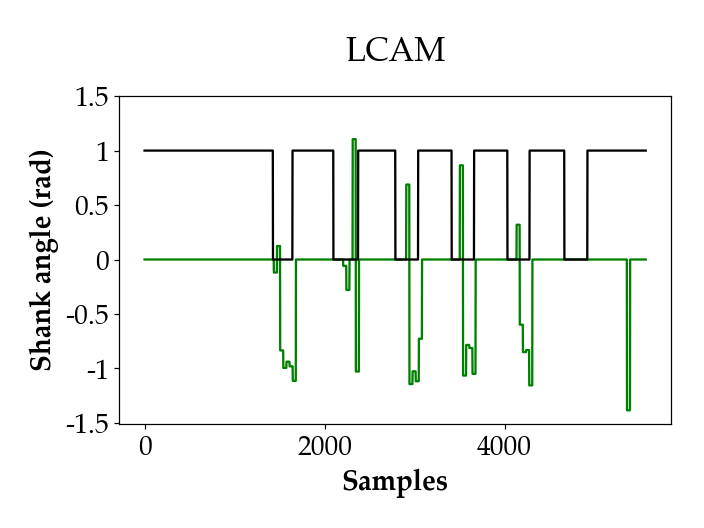

<IPython.core.display.Javascript object>


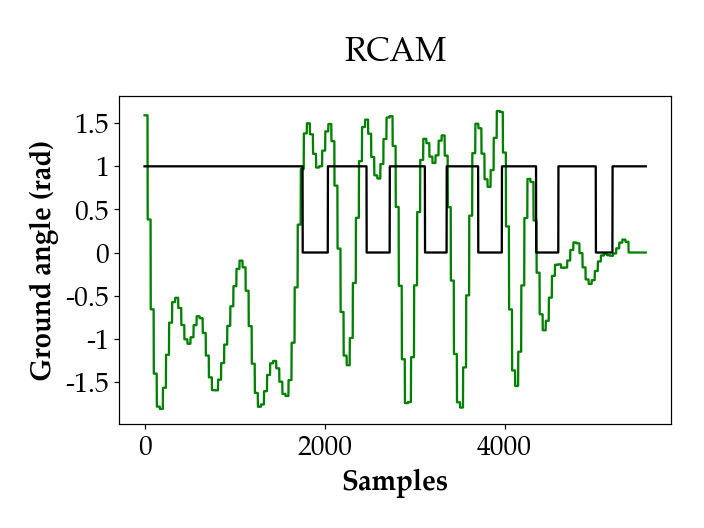

<IPython.core.display.Javascript object>


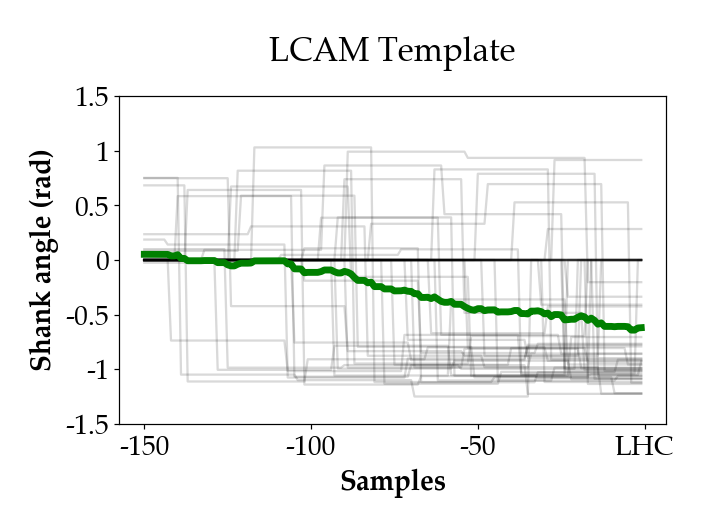

<IPython.core.display.Javascript object>


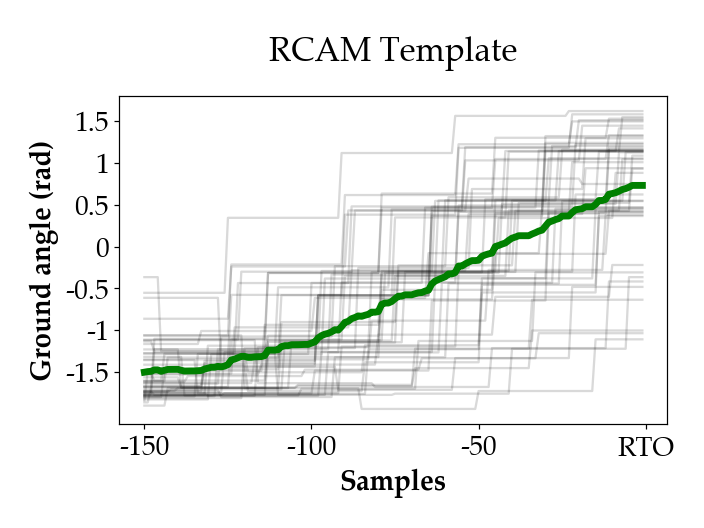

<IPython.core.display.Javascript object>


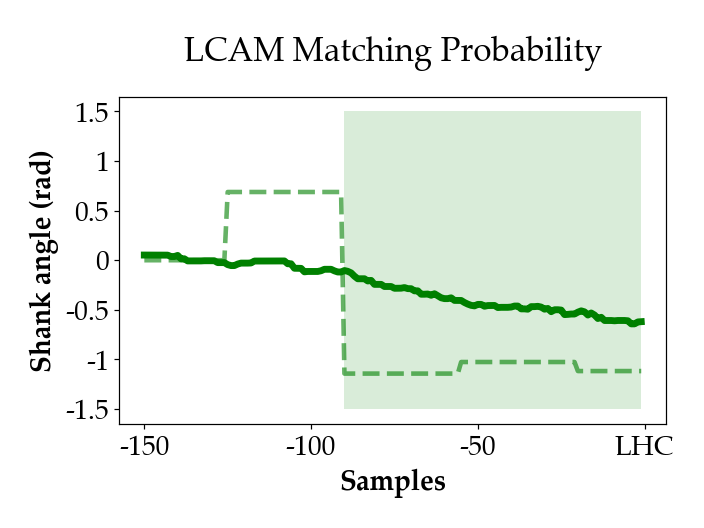

<IPython.core.display.Javascript object>


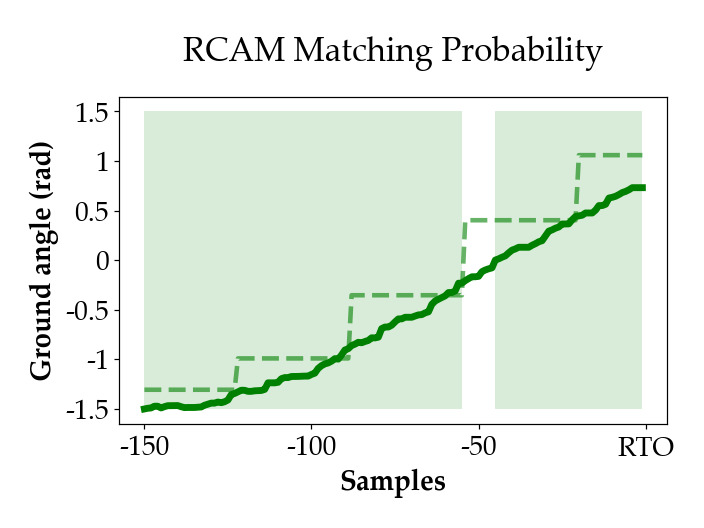

In [9]:
# Use filekey 0
Lwindownum = 192
Rwindownum = 150

plt.figure()
plt.plot(filedict[filekeys[0]][1],color='g')
plt.plot(filedict[filekeys[0]][5],color='k')
plt.plot()
plt.title('LCAM',y=1.08)
plt.yticks(np.arange(-1.5,2,0.5), ('-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Shank angle (rad)',fontweight = 'bold')
# plt.savefig('Shankangle.png', dpi=300)

plt.figure()
plt.plot(filedict[filekeys[0]][2],color='g')
plt.plot(filedict[filekeys[0]][6],color='k')
plt.title('RCAM',y=1.08)
plt.yticks(np.arange(-1.5,2,0.5), ('-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Ground angle (rad)',fontweight = 'bold')
# plt.savefig('Groundangle.png', dpi=300)

plt.figure()
for temp in range(len(LHC_templates)):
    plt.plot(LHC_templates[temp],color='k',alpha=0.15)
avg_LHC_template = sum(LHC_templates)/len(LHC_templates)
plt.plot(avg_LHC_template,color='g',linewidth=4.5)
plt.title('LCAM Template',y=1.08)
plt.xticks(np.arange(0,200,50), ('-150', '-100', '-50', 'LHC'))
plt.yticks(np.arange(-1.5,2,0.5), ('-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Shank angle (rad)',fontweight = 'bold')
# plt.savefig('Shankangle_temp.png', dpi=300)

plt.figure()
for temp in range(len(RTO_templates)):
    plt.plot(RTO_templates[temp],color='k',alpha=0.15)
avg_RTO_template = sum(RTO_templates)/len(RTO_templates)
plt.plot(avg_RTO_template,color='g',linewidth=4.5)
plt.title('RCAM Template',y=1.08)
plt.xticks(np.arange(0,200,50), ('-150', '-100', '-50', 'RTO'))
plt.yticks(np.arange(-1.5,2,0.5), ('-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Ground angle (rad)',fontweight = 'bold')
# plt.savefig('Groundangle_temp.png', dpi=300)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(avg_LHC_template,color='g',linewidth=4.5)
ax2.plot(testwin_Lcam[Lwindownum],color='g',alpha=0.6,linewidth=3,linestyle='--')
ax2.fill_between(np.arange(150), -1.5, 1.5, where= Lcambinwin[Lwindownum] > 0.5, facecolor='green', alpha=0.15)
plt.title('LCAM Matching Probability',y=1.08)
plt.xticks(np.arange(0,200,50), ('-150', '-100', '-50', 'LHC'))
plt.yticks(np.arange(-1.5,2,0.5), ('-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Shank angle (rad)',fontweight = 'bold')
# plt.savefig('Shankangle_conv.png', dpi=300)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(avg_RTO_template,color='g',linewidth=4.5)
ax1.plot(testwin_Rcam[Rwindownum],color='g',alpha=0.6,linewidth=3,linestyle='--')
ax1.fill_between(np.arange(150), -1.5, 1.5, where= Rcambinwin[Rwindownum] > 0.5, facecolor='green', alpha=0.15)
plt.title('RCAM Matching Probability',y=1.08)
plt.xticks(np.arange(0,200,50), ('-150', '-100', '-50', 'RTO'))
plt.yticks(np.arange(-1.5,2,0.5), ('-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Ground angle (rad)',fontweight = 'bold')
# plt.savefig('Groundangle_conv.png', dpi=300)

### Show probability estimates and event detection (IMU, CAM, FUSED)- use filekey 7 only

<IPython.core.display.Javascript object>


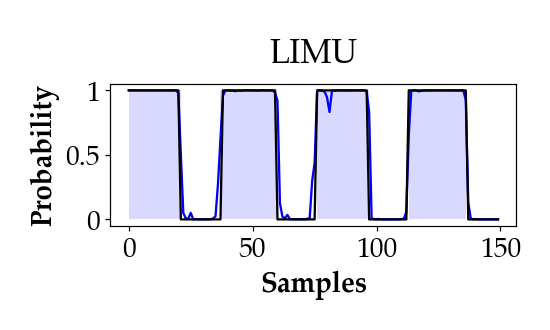

<IPython.core.display.Javascript object>


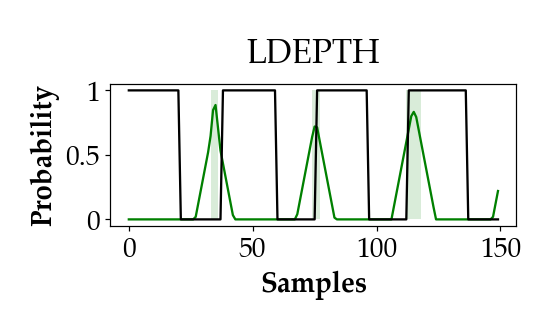

<IPython.core.display.Javascript object>


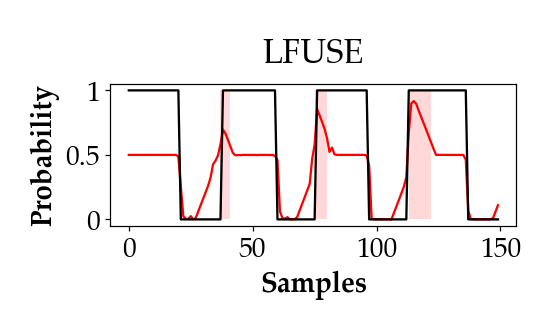

<IPython.core.display.Javascript object>


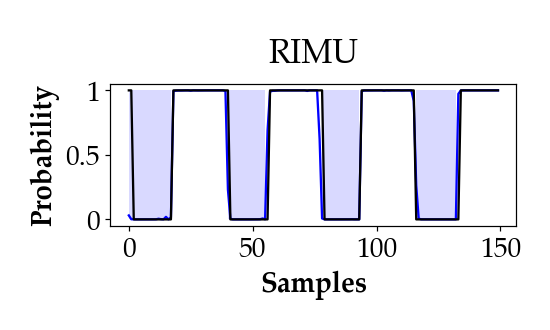

<IPython.core.display.Javascript object>


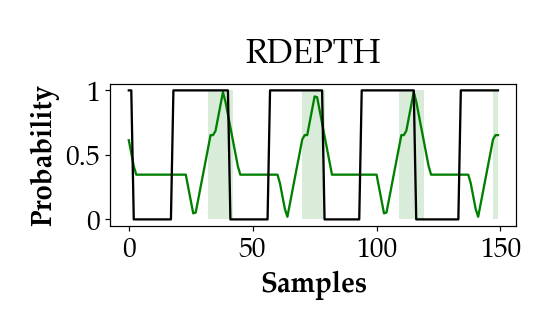

<IPython.core.display.Javascript object>


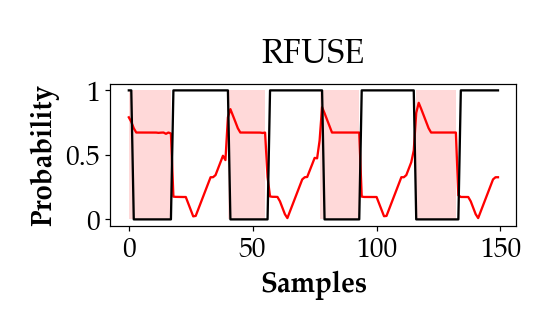

In [11]:
# Use filekey 7
lhc_start = 100
lhc_end = 250

fig4 = plt.figure(figsize=(5,3))
ax4 = fig4.add_subplot(111)
ax4.plot(LDA_Lprob[lhc_start:lhc_end,1],color='b')
ax4.plot(trueL[lhc_start:lhc_end],color='k')
ax4.fill_between(np.arange(150), 0, 1, where= LDA_Lprob[lhc_start:lhc_end,1] > 0.5, facecolor='b', alpha=0.15)
plt.title('LIMU', y=1.08)
plt.xticks(np.arange(0,200,50), ('0', '50', '100', '150'))
plt.yticks(np.arange(0,1.5,0.5), ('0', '0.5', '1'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Probability',fontweight = 'bold')
# plt.savefig('LIMUdetect.png', dpi=300)

fig3 = plt.figure(figsize=(5,3))
ax3 = fig3.add_subplot(111)
ax3.plot(Lcamprob[lhc_start:lhc_end],color='g')
ax3.plot(trueL[lhc_start:lhc_end],color='k')
ax3.fill_between(np.arange(150), 0, 1, where= Lcamprob[lhc_start:lhc_end] > 0.55, facecolor='g', alpha=0.15)
plt.title('LDEPTH', y=1.08)
plt.xticks(np.arange(0,200,50), ('0', '50', '100', '150'))
plt.yticks(np.arange(0,1.5,0.5), ('0', '0.5', '1'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Probability',fontweight = 'bold')
# plt.savefig('LCAMdetect.png', dpi=300)

fig5 = plt.figure(figsize=(5,3))
ax5 = fig5.add_subplot(111)
ax5.plot(0.5*LDA_Lprob[lhc_start:lhc_end,1] + 0.5*Lcamprob[lhc_start:lhc_end],color='r')
ax5.plot(trueL[lhc_start:lhc_end],color='k')
ax5.fill_between(np.arange(150), 0, 1, where= (0.5*LDA_Lprob[lhc_start:lhc_end,1] + 0.5*Lcamprob[lhc_start:lhc_end]) > 0.55, facecolor='r', alpha=0.15)
plt.title('LFUSE', y=1.08)
plt.xticks(np.arange(0,200,50), ('0', '50', '100', '150'))
plt.yticks(np.arange(0,1.5,0.5), ('0', '0.5', '1'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Probability',fontweight = 'bold')
# plt.savefig('LFUSEDdetect.png', dpi=300)

rto_start = 100
rto_end = 250

fig7 = plt.figure(figsize=(5,3))
ax7 = fig7.add_subplot(111)
ax7.plot(LDA_Rprob[rto_start:rto_end,1],color='b')
ax7.plot(trueR[rto_start:rto_end],color='k')
ax7.fill_between(np.arange(150), 0, 1, where= LDA_Rprob[rto_start:rto_end,1] < 0.55, facecolor='b', alpha=0.15)
plt.title('RIMU', y=1.08)
plt.xticks(np.arange(0,200,50), ('0', '50', '100', '150'))
plt.yticks(np.arange(0,1.5,0.5), ('0', '0.5', '1'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Probability',fontweight = 'bold')
# plt.savefig('RIMUdetect.png', dpi=300)

fig6 = plt.figure(figsize=(5,3))
ax6 = fig6.add_subplot(111)
ax6.plot(Rcamprob[rto_start:rto_end],color='g')
ax6.plot(trueR[rto_start:rto_end],color='k')
ax6.fill_between(np.arange(150), 0, 1, where= Rcamprob[rto_start:rto_end] > 0.55, facecolor='g', alpha=0.15)
plt.title('RDEPTH', y=1.08)
plt.xticks(np.arange(0,200,50), ('0', '50', '100', '150'))
plt.yticks(np.arange(0,1.5,0.5), ('0', '0.5', '1'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Probability',fontweight = 'bold')
# plt.savefig('RCAMdetect.png', dpi=300)

fig8 = plt.figure(figsize=(5,3))
ax8 = fig8.add_subplot(111)
ax8.plot(0.5*LDA_Rprob[rto_start:rto_end,0] + 0.5*Rcamprob[rto_start:rto_end],color='r')
ax8.plot(trueR[rto_start:rto_end],color='k')
ax8.fill_between(np.arange(150), 0, 1, where= (0.5*LDA_Rprob[rto_start:rto_end,0] + 0.5*Rcamprob[rto_start:rto_end]) > 0.55, facecolor='r', alpha=0.15)
plt.title('RFUSE', y=1.08)
plt.xticks(np.arange(0,200,50), ('0', '50', '100', '150'))
plt.yticks(np.arange(0,1.5,0.5), ('0', '0.5', '1'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Probability',fontweight = 'bold')
# plt.savefig('RFUSEDdetect.png', dpi=300)

### Make figures for St/Sw classifier and sliding windows for IMU

<IPython.core.display.Javascript object>


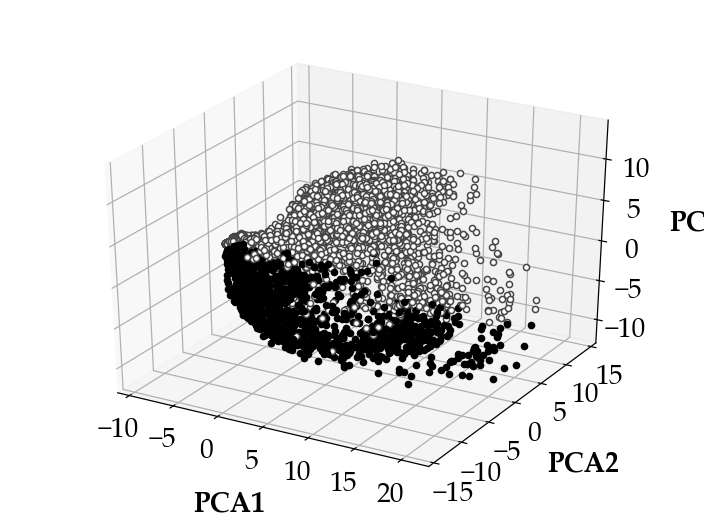

<IPython.core.display.Javascript object>


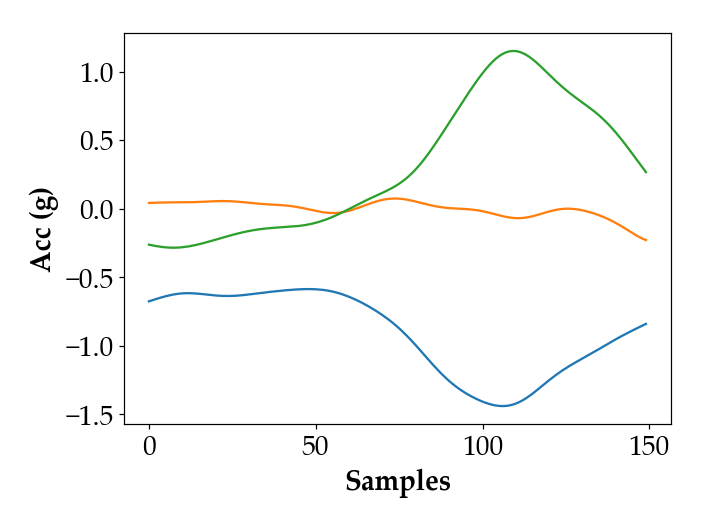

<IPython.core.display.Javascript object>


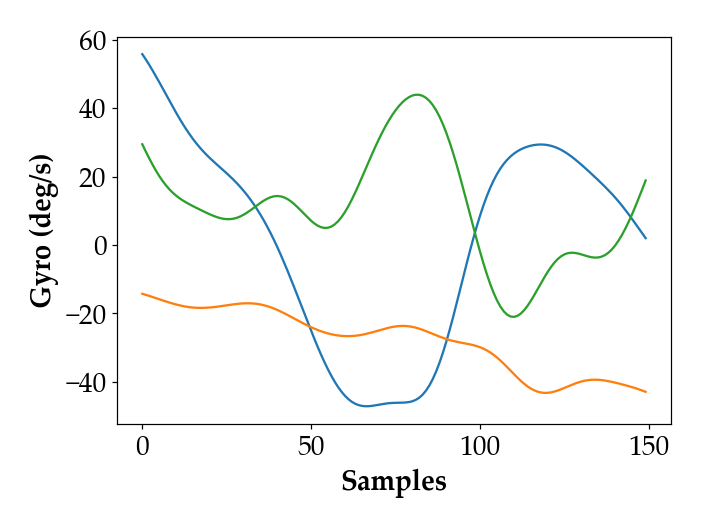

In [12]:
allwins = alldict['Combined'][0]
allfeats = alldict['Combined'][1]
allLtruth = alldict['Combined'][2]
allRtruth = alldict['Combined'][3]

scaler = preprocessing.StandardScaler()
pca = PCA(n_components = 25)

allfeats_scale = scaler.fit(allfeats).transform(allfeats)
allfeats_pca = pca.fit(allfeats_scale).transform(allfeats_scale)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(np.shape(allfeats_pca)[0]):
    if allLtruth[i] == 0:
        ax.scatter(allfeats_pca[i,0], allfeats_pca[i,1], allfeats_pca[i,2], color = 'k', s = 16)
    else:
        ax.scatter(allfeats_pca[i,0], allfeats_pca[i,1], allfeats_pca[i,2], facecolors='w', edgecolors= (70/255.,70/255.,70/255.), s = 16)
ax = fig.gca(projection='3d')
ax.set_xlabel('PCA1',fontweight='bold',labelpad=20)        
ax.set_ylabel('PCA2',fontweight='bold',labelpad=20)
ax.set_zlabel('PCA3',fontweight='bold',labelpad=20)

# IMU acc. representative window
plt.figure()
plt.plot(allwins[150,:,0])
plt.plot(allwins[150,:,1])
plt.plot(allwins[150,:,2])
plt.xticks(np.arange(0,200,50), ('0', '50', '100', '150'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Acc (g)',fontweight = 'bold')

# IMU gyro representative window
plt.figure()
plt.plot(allwins[150,:,3])
plt.plot(allwins[150,:,4])
plt.plot(allwins[150,:,5])
plt.xticks(np.arange(0,200,50), ('0', '50', '100', '150'))
plt.xlabel('Samples',fontweight = 'bold')
plt.ylabel('Gyro (deg/s)',fontweight = 'bold')

### Summarize residuals and make histogram plots

LHC outlier: 0 / LCAM outlier: 7 / LFUSE outlier: 6
RTO outlier: 0 / RCAM outlier: 0 / RFUSE outlier: 0
LHC mean/sd: -23.1578947368/69.0577661762
CAM LHC mean/sd: -33.6/106.597560948
FUSE LHC mean/sd: -14.7058823529/63.2564943942
RTO mean/sd: -5.55555555556/41.2609880614
CAM RTO mean/sd: -7.22222222222/85.2320724425
FUSE RTO mean/sd: -5.0/38.6221007542


<IPython.core.display.Javascript object>


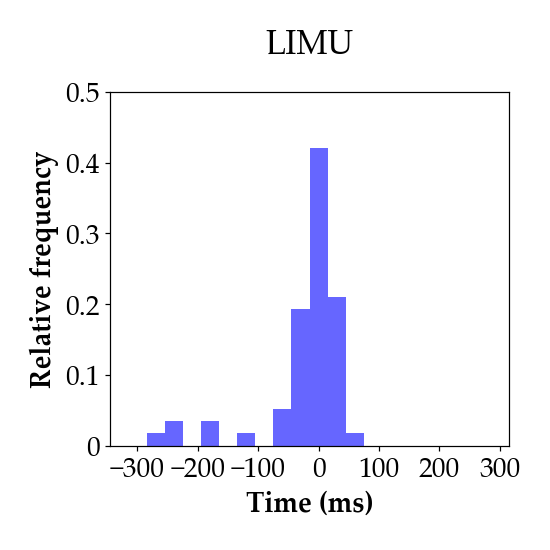

<IPython.core.display.Javascript object>


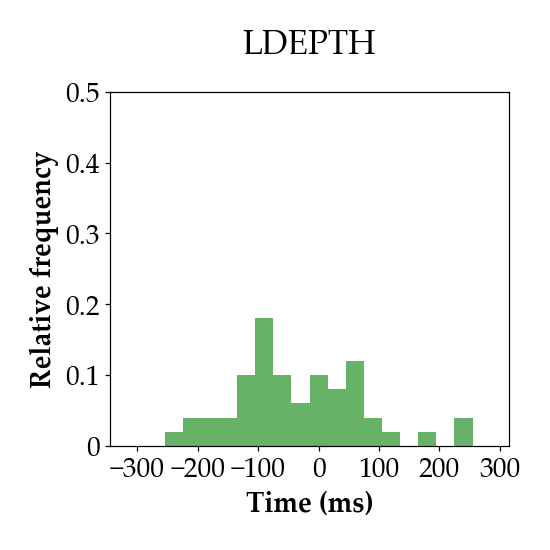

<IPython.core.display.Javascript object>


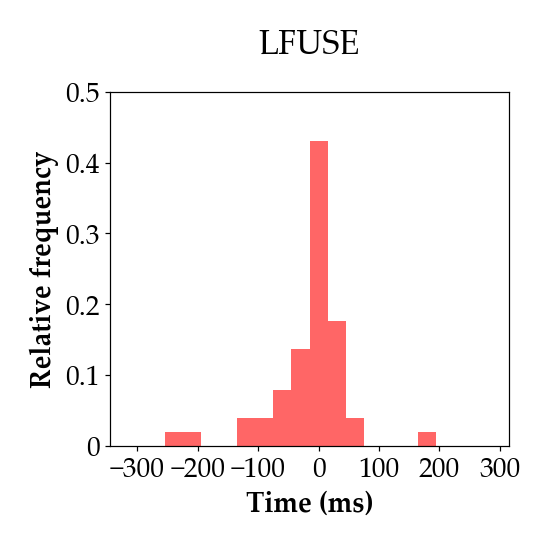

<IPython.core.display.Javascript object>


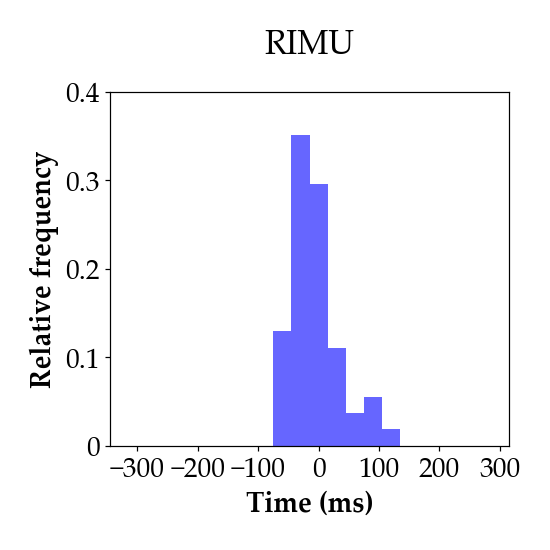

<IPython.core.display.Javascript object>


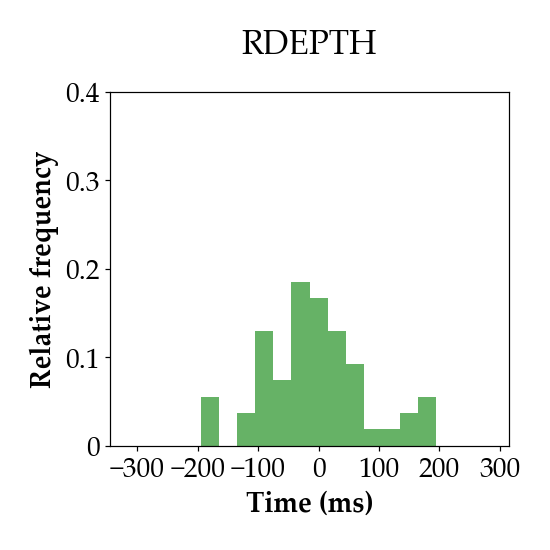

C:\Users\bhu\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


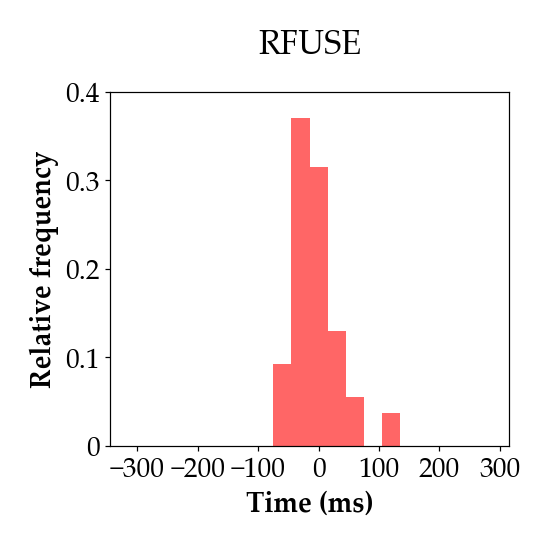

In [14]:
all_lhc_resid = np.concatenate(all_lhc_resid)
all_rto_resid = np.concatenate(all_rto_resid)
all_lcam_resid = np.concatenate(all_lcam_resid)
all_rcam_resid = np.concatenate(all_rcam_resid)
all_lfuse_resid = np.concatenate(all_lfuse_resid)
all_rfuse_resid = np.concatenate(all_rfuse_resid)

all_lhc_resid_inrange = [i for i in all_lhc_resid if abs(i) < 400]
all_rto_resid_inrange = [i for i in all_rto_resid if abs(i) < 600]
all_lcam_resid_inrange = [i for i in all_lcam_resid if abs(i) < 400]
all_rcam_resid_inrange = [i for i in all_rcam_resid if abs(i) < 600]
all_lfuse_resid_inrange = [i for i in all_lfuse_resid if abs(i) < 400]
all_rfuse_resid_inrange = [i for i in all_rfuse_resid if abs(i) < 600]

all_lhc_resid_outrange = [i for i in all_lhc_resid if abs(i) > 400]
all_rto_resid_outrange = [i for i in all_rto_resid if abs(i) > 600]
all_lcam_resid_outrange = [i for i in all_lcam_resid if abs(i) > 400]
all_rcam_resid_outrange = [i for i in all_rcam_resid if abs(i) > 600]
all_lfuse_resid_outrange = [i for i in all_lfuse_resid if abs(i) > 400]
all_rfuse_resid_outrange = [i for i in all_rfuse_resid if abs(i) > 600]

print('LHC outlier: {} / LCAM outlier: {} / LFUSE outlier: {}'.format(len(all_lhc_resid_outrange), len(all_lcam_resid_outrange), len(all_lfuse_resid_outrange)))
print('RTO outlier: {} / RCAM outlier: {} / RFUSE outlier: {}'.format(len(all_rto_resid_outrange), len(all_rcam_resid_outrange), len(all_rfuse_resid_outrange)))

print('LHC mean/sd: {}/{}'.format(np.mean(all_lhc_resid_inrange),np.std(all_lhc_resid_inrange)))
print('CAM LHC mean/sd: {}/{}'.format(np.mean(all_lcam_resid_inrange),np.std(all_lcam_resid_inrange)))
print('FUSE LHC mean/sd: {}/{}'.format(np.mean(all_lfuse_resid_inrange),np.std(all_lfuse_resid_inrange)))

print('RTO mean/sd: {}/{}'.format(np.mean(all_rto_resid_inrange),np.std(all_rto_resid_inrange)))
print('CAM RTO mean/sd: {}/{}'.format(np.mean(all_rcam_resid_inrange),np.std(all_rcam_resid_inrange)))
print('FUSE RTO mean/sd: {}/{}'.format(np.mean(all_rfuse_resid_inrange),np.std(all_rfuse_resid_inrange)))

all_resid = {'LHC': all_lhc_resid, 'RTO': all_rto_resid, 'LCAM': all_lcam_resid, 'RCAM': all_rcam_resid, 'LFUSE': all_lfuse_resid, 'RFUSE': all_rfuse_resid}
# sio.savemat('allresiduals_allIMU_RF.mat',all_resid)

lhc_wts = np.ones_like(all_lhc_resid_inrange)/float(len(all_lhc_resid_inrange))
lcam_wts = np.ones_like(all_lcam_resid_inrange)/float(len(all_lcam_resid_inrange))
lfuse_wts = np.ones_like(all_lfuse_resid_inrange)/float(len(all_lfuse_resid_inrange))

plt.figure(figsize=(5,5))
plt.hist(all_lhc_resid_inrange,range(-315,315,30),color='b',alpha=0.6,weights=lhc_wts)
plt.title('LIMU',y=1.08)
plt.xticks(range(-300,400,100))
plt.yticks(np.arange(0,0.6,0.1), ('0', '0.1', '0.2', '0.3', '0.4', '0.5'))
plt.xlabel('Time (ms)',fontweight = 'bold')
plt.ylabel('Relative frequency',fontweight = 'bold')
plt.savefig('LIMU.png', dpi=300)

plt.figure(figsize=(5,5))
plt.hist(all_lcam_resid_inrange,range(-315,315,30),color='g',alpha=0.6,weights=lcam_wts)
plt.title('LDEPTH',y=1.08)
plt.xticks(range(-300,400,100))
plt.yticks(np.arange(0,0.6,0.1), ('0', '0.1', '0.2', '0.3', '0.4', '0.5'))
plt.xlabel('Time (ms)',fontweight = 'bold')
plt.ylabel('Relative frequency',fontweight = 'bold')
plt.savefig('LCAM.png', dpi=300)

plt.figure(figsize=(5,5))
plt.hist(all_lfuse_resid_inrange,range(-315,315,30),color='r',alpha=0.6,weights=lfuse_wts)
plt.title('LFUSE',y=1.08)
plt.xticks(range(-300,400,100))
plt.yticks(np.arange(0,0.6,0.1), ('0', '0.1', '0.2', '0.3', '0.4', '0.5'))
plt.xlabel('Time (ms)',fontweight = 'bold')
plt.ylabel('Relative frequency',fontweight = 'bold')
plt.savefig('LFUSE.png', dpi=300)

rto_wts = np.ones_like(all_rto_resid_inrange)/float(len(all_rto_resid_inrange))
rcam_wts = np.ones_like(all_rcam_resid_inrange)/float(len(all_rcam_resid_inrange))
rfuse_wts = np.ones_like(all_rfuse_resid_inrange)/float(len(all_rfuse_resid_inrange))

plt.figure(figsize=(5,5))
plt.hist(all_rto_resid_inrange,range(-315,315,30),color='b',alpha=0.6,weights=rto_wts)
plt.title('RIMU', y = 1.08)
plt.xticks(range(-300,400,100))
plt.yticks(np.arange(0,0.5,0.1), ('0', '0.1', '0.2', '0.3', '0.4'))
plt.xlabel('Time (ms)',fontweight = 'bold')
plt.ylabel('Relative frequency',fontweight = 'bold')
plt.savefig('RIMU.png', dpi=300)

plt.figure(figsize=(5,5))
plt.hist(all_rcam_resid_inrange,range(-315,315,30),color='g',alpha=0.6,weights=rcam_wts)
plt.title('RDEPTH', y = 1.08)
plt.xticks(range(-300,400,100))
plt.yticks(np.arange(0,0.5,0.1), ('0', '0.1', '0.2', '0.3', '0.4'))
plt.xlabel('Time (ms)',fontweight = 'bold')
plt.ylabel('Relative frequency',fontweight = 'bold')
plt.savefig('RCAM.png', dpi=300)

plt.figure(figsize=(5,5))
plt.hist(all_rfuse_resid_inrange,range(-315,315,30),color='r',alpha=0.6,weights=rfuse_wts)
plt.title('RFUSE', y = 1.08)
plt.xticks(range(-300,400,100))
plt.yticks(np.arange(0,0.5,0.1), ('0', '0.1', '0.2', '0.3', '0.4'))
plt.xlabel('Time (ms)',fontweight = 'bold')
plt.ylabel('Relative frequency',fontweight = 'bold')
plt.savefig('RFUSE.png', dpi=300)